# Final project : Stroke prediction

## Machine Learning for Healthcare ##
Jean Baptiste Reynier - Mickael Elhaik

In [66]:
import pandas as pd
import numpy as np
from scipy import stats
import collections
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import collections
import imblearn.under_sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D
from keras import losses
from tensorflow.keras import optimizers
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('../data/stroke_data_cleanedJB.csv')
df.head()

id  gender   age  hypertension  heart_disease ever_married work_type  \
0  30669    Male   3.0             0              0           No  children   
1  30468    Male  58.0             1              0          Yes   Private   
2  16523  Female   8.0             0              0           No   Private   
3  56543  Female  70.0             0              0          Yes   Private   
4  46136    Male  14.0             0              0           No  children   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Rural              95.12  18.0     never smoked       0  
1          Urban              87.96  39.2     never smoked       0  
2          Urban             110.89  17.6     never smoked       0  
3          Rural              69.04  35.9  formerly smoked       0  
4          Rural             161.28  19.1     never smoked       0

# Preprocessing

Convert smoking status to cardinal, making sure to keep the NaN values as null:

In [4]:
df.loc[df["smoking_status"] == "never smoked", "smoking_status_cardinal"] = 0
df.loc[df["smoking_status"] == "formerly smoked", "smoking_status_cardinal"] = 1
df.loc[df["smoking_status"] == "smokes", "smoking_status_cardinal"] = 2

Convert all the binary columns to 0/1:

In [5]:
df.loc[df["gender"] == "Male", "gender"] = 0
df.loc[df["gender"] == "Female", "gender"] = 1

df.loc[df["ever_married"] == "No", "ever_married"] = 0
df.loc[df["ever_married"] == "Yes", "ever_married"] = 1

df.loc[df["Residence_type"] == "Rural", "Residence_type"] = 0
df.loc[df["Residence_type"] == "Urban", "Residence_type"] = 1

For work_type, since there are 5 categories, We convert them to one-hot encoding:

In [6]:
df_onehot_worktype = pd.get_dummies(df['work_type'])
df_onehot_worktype.columns = ["work_type_"+col for col in df_onehot_worktype.columns]
df = pd.concat([df, df_onehot_worktype], axis=1)

In [7]:
df_imputation = df.drop(columns=["smoking_status", "work_type", "id"])

Count total number of strokes, and save 20% for the testing dataset (and then save the same number of non-stroke rows). I chose only rows with non-NaN rows, so as not to impute anything in the test data (which could skew our results):

In [8]:
sum(df_imputation["stroke"] == 1)

783

In [9]:
num_stroke_test = round(sum(df_imputation["stroke"] == 1) / 5)
num_stroke_test

157

First shuffle the dataframe:

In [10]:
df_imputation = df_imputation.sample(frac=1, random_state=1).reset_index(drop=True)

Generate test dataset before imputation, taking only non NaN values:

In [11]:
index_test_stroke = df_imputation.dropna().loc[df_imputation.dropna()["stroke"] == 1,:].iloc[0:num_stroke_test,:].index
index_test_nonstroke = df_imputation.dropna().loc[df_imputation.dropna()["stroke"] == 0,:].iloc[0:num_stroke_test,:].index

In [12]:
test_dataset = pd.concat([df_imputation.loc[index_test_stroke,:], df_imputation.loc[index_test_nonstroke,:]])
test_dataset

gender    age  hypertension  heart_disease ever_married Residence_type  \
10       0  58.00             0              1            1              0   
53       1  78.00             0              0            1              1   
59       0  59.00             0              0            1              0   
240      1  68.00             0              0            0              1   
326      0  79.00             0              0            1              1   
..     ...    ...           ...            ...          ...            ...   
195      1  24.00             0              0            0              0   
196      1  76.00             0              0            1              1   
197      1   0.24             0              0            0              0   
198      1  33.00             0              0            0              0   
199      0  46.00             0              0            1              0   

     avg_glucose_level   bmi  stroke  smoking_status_cardinal  \
10               63.26  29.6       1                      0.0   
53               81.59  32.3       1                      0.0   
59               91.59  31.9       1                      2.0   
240             231.96  36.7       1                      2.0   
326              87.06  24.3       1                      1.0   
..                 ...   ...     ...                      ...   
195              68.13  20.2       0                      0.0   
196             106.84  27.0       0                      1.0   
197              89.24  13.8       0                      0.0   
198             114.27  25.3       0                      0.0   
199             100.00  31.4       0                      1.0   

     work_type_Govt_job  work_type_Never_worked  work_type_Private  \
10                    0                       0                  1   
53                    0                       0                  1   
59                    0                       0                  1   
240                   0                       0                  0   
326                   0                       0                  0   
..                  ...                     ...                ...   
195                   0                       0                  1   
196                   0                       0                  0   
197                   0                       0                  0   
198                   1                       0                  0   
199                   0                       0                  1   

     work_type_Self-employed  work_type_children  
10                         0                   0  
53                         0                   0  
59                         0                   0  
240                        1                   0  
326                        1                   0  
..                       ...                 ...  
195                        0                   0  
196                        1                   0  
197                        0                   1  
198                        0                   0  
199                        0                   0  

[314 rows x 15 columns]

Remove training samples from dataset:

In [13]:
train_dataset = df_imputation.drop(index=index_test_stroke)
train_dataset = train_dataset.drop(index=index_test_nonstroke)
train_dataset

gender   age  hypertension  heart_disease ever_married Residence_type  \
3          1  65.0             1              0            1              0   
17         0  17.0             0              0            0              1   
18         1  65.0             0              0            1              0   
27         1  57.0             0              0            1              1   
30         1  68.0             0              1            1              1   
...      ...   ...           ...            ...          ...            ...   
43384      0   3.0             0              0            0              1   
43385      1   0.4             0              0            0              1   
43386      0  60.0             0              0            1              1   
43387      0  46.0             0              0            1              1   
43388      1  81.0             0              1            1              0   

       avg_glucose_level   bmi  stroke  smoking_status_cardinal  \
3                  81.70  29.5       0                      NaN   
17                 82.57  28.1       0                      NaN   
18                 97.54  24.4       0                      NaN   
27                139.73   NaN       1                      2.0   
30                235.75  32.2       0                      NaN   
...                  ...   ...     ...                      ...   
43384              58.50  21.0       0                      0.0   
43385             105.52  13.6       0                      0.0   
43386             243.65  19.4       0                      2.0   
43387              62.51  24.1       0                      NaN   
43388              71.47  29.2       0                      NaN   

       work_type_Govt_job  work_type_Never_worked  work_type_Private  \
3                       0                       0                  0   
17                      0                       0                  1   
18                      1                       0                  0   
27                      0                       0                  0   
30                      0                       0                  1   
...                   ...                     ...                ...   
43384                   0                       0                  0   
43385                   0                       0                  0   
43386                   0                       0                  1   
43387                   0                       0                  0   
43388                   0                       0                  0   

       work_type_Self-employed  work_type_children  
3                            1                   0  
17                           0                   0  
18                           0                   0  
27                           1                   0  
30                           0                   0  
...                        ...                 ...  
43384                        0                   1  
43385                        0                   1  
43386                        0                   0  
43387                        1                   0  
43388                        1                   0  

[43075 rows x 15 columns]

Impute missing values (in smoking_status and bmi):

In [14]:
imp = KNNImputer(n_neighbors=5)
train_dataset_imputed = imp.fit_transform(train_dataset)

In [15]:
df_train_dataset_imputed = pd.DataFrame(train_dataset_imputed, columns=train_dataset.columns)
df_train_dataset_imputed

gender   age  hypertension  heart_disease  ever_married  \
0         1.0  65.0           1.0            0.0           1.0   
1         0.0  17.0           0.0            0.0           0.0   
2         1.0  65.0           0.0            0.0           1.0   
3         1.0  57.0           0.0            0.0           1.0   
4         1.0  68.0           0.0            1.0           1.0   
...       ...   ...           ...            ...           ...   
43070     0.0   3.0           0.0            0.0           0.0   
43071     1.0   0.4           0.0            0.0           0.0   
43072     0.0  60.0           0.0            0.0           1.0   
43073     0.0  46.0           0.0            0.0           1.0   
43074     1.0  81.0           0.0            1.0           1.0   

       Residence_type  avg_glucose_level    bmi  stroke  \
0                 0.0              81.70  29.50     0.0   
1                 1.0              82.57  28.10     0.0   
2                 0.0              97.54  24.40     0.0   
3                 1.0             139.73  36.26     1.0   
4                 1.0             235.75  32.20     0.0   
...               ...                ...    ...     ...   
43070             1.0              58.50  21.00     0.0   
43071             1.0             105.52  13.60     0.0   
43072             1.0             243.65  19.40     0.0   
43073             1.0              62.51  24.10     0.0   
43074             0.0              71.47  29.20     0.0   

       smoking_status_cardinal  work_type_Govt_job  work_type_Never_worked  \
0                          0.6                 0.0                     0.0   
1                          0.6                 0.0                     0.0   
2                          0.8                 1.0                     0.0   
3                          2.0                 0.0                     0.0   
4                          0.2                 0.0                     0.0   
...                        ...                 ...                     ...   
43070                      0.0                 0.0                     0.0   
43071                      0.0                 0.0                     0.0   
43072                      2.0                 0.0                     0.0   
43073                      0.6                 0.0                     0.0   
43074                      0.4                 0.0                     0.0   

       work_type_Private  work_type_Self-employed  work_type_children  
0                    0.0                      1.0                 0.0  
1                    1.0                      0.0                 0.0  
2                    0.0                      0.0                 0.0  
3                    0.0                      1.0                 0.0  
4                    1.0                      0.0                 0.0  
...                  ...                      ...                 ...  
43070                0.0                      0.0                 1.0  
43071                0.0                      0.0                 1.0  
43072                1.0                      0.0                 0.0  
43073                0.0                      1.0                 0.0  
43074                0.0                      1.0                 0.0  

[43075 rows x 15 columns]

In [16]:
df_train_dataset_imputed["gender"].dtype

dtype('float64')

Since imputation for cardinal smoking status gives non-cardinal values, need to round to integer:

In [17]:
df_train_dataset_imputed.loc[:,"smoking_status_cardinal"] = round(df_train_dataset_imputed.loc[:,"smoking_status_cardinal"])
df_train_dataset_imputed.loc[:,"smoking_status_cardinal"] = df_train_dataset_imputed.loc[:,"smoking_status_cardinal"].astype('float64')
df_train_dataset_imputed

gender   age  hypertension  heart_disease  ever_married  \
0         1.0  65.0           1.0            0.0           1.0   
1         0.0  17.0           0.0            0.0           0.0   
2         1.0  65.0           0.0            0.0           1.0   
3         1.0  57.0           0.0            0.0           1.0   
4         1.0  68.0           0.0            1.0           1.0   
...       ...   ...           ...            ...           ...   
43070     0.0   3.0           0.0            0.0           0.0   
43071     1.0   0.4           0.0            0.0           0.0   
43072     0.0  60.0           0.0            0.0           1.0   
43073     0.0  46.0           0.0            0.0           1.0   
43074     1.0  81.0           0.0            1.0           1.0   

       Residence_type  avg_glucose_level    bmi  stroke  \
0                 0.0              81.70  29.50     0.0   
1                 1.0              82.57  28.10     0.0   
2                 0.0              97.54  24.40     0.0   
3                 1.0             139.73  36.26     1.0   
4                 1.0             235.75  32.20     0.0   
...               ...                ...    ...     ...   
43070             1.0              58.50  21.00     0.0   
43071             1.0             105.52  13.60     0.0   
43072             1.0             243.65  19.40     0.0   
43073             1.0              62.51  24.10     0.0   
43074             0.0              71.47  29.20     0.0   

       smoking_status_cardinal  work_type_Govt_job  work_type_Never_worked  \
0                          1.0                 0.0                     0.0   
1                          1.0                 0.0                     0.0   
2                          1.0                 1.0                     0.0   
3                          2.0                 0.0                     0.0   
4                          0.0                 0.0                     0.0   
...                        ...                 ...                     ...   
43070                      0.0                 0.0                     0.0   
43071                      0.0                 0.0                     0.0   
43072                      2.0                 0.0                     0.0   
43073                      1.0                 0.0                     0.0   
43074                      0.0                 0.0                     0.0   

       work_type_Private  work_type_Self-employed  work_type_children  
0                    0.0                      1.0                 0.0  
1                    1.0                      0.0                 0.0  
2                    0.0                      0.0                 0.0  
3                    0.0                      1.0                 0.0  
4                    1.0                      0.0                 0.0  
...                  ...                      ...                 ...  
43070                0.0                      0.0                 1.0  
43071                0.0                      0.0                 1.0  
43072                1.0                      0.0                 0.0  
43073                0.0                      1.0                 0.0  
43074                0.0                      1.0                 0.0  

[43075 rows x 15 columns]

Oversample the training data so that we have an equal number of strokes/non-strokes:

In [18]:
X_train = df_train_dataset_imputed.drop(columns="stroke")
y_train = df_train_dataset_imputed.loc[:, "stroke"]
rus = RandomOverSampler(random_state=1)
X_train_oversampled, y_train_oversampled = rus.fit_resample(X_train, y_train)
print('Ratio of strokes over the total number of train samples is:', y_train_oversampled.sum()/y_train_oversampled.shape[0])

Ratio of strokes over the total number of train samples is: 0.5


In [19]:
train_imputed = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
train_imputed.shape

(84898, 15)

In [20]:
train_imputed_notoversampled = pd.concat([X_train, y_train], axis=1)
train_imputed_notoversampled.shape

(43075, 15)

In [21]:
X_test = test_dataset.drop(columns="stroke")
y_test = test_dataset.loc[:, "stroke"]

In [22]:
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
print('Ratio of strokes over the total number of train samples is:', y_train_undersampled.sum()/y_train_undersampled.shape[0])

Ratio of strokes over the total number of train samples is: 0.5


Summary of the shapes

In [23]:
print('X_train_undersampled shape:',X_train_undersampled.shape)
print('X_train_oversampled shape:',X_train_oversampled.shape)
print('X_test shape:',X_test.shape)

X_train_undersampled shape: (1252, 14)
X_train_oversampled shape: (84898, 14)
X_test shape: (314, 14)


Now, we are going to train each of the principal classification model we worked on in class on the oversampled train dataset and evaluate the performance on the test dataset. 

# Logistic regression

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


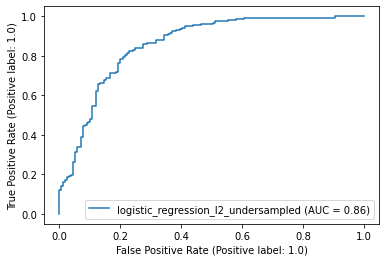

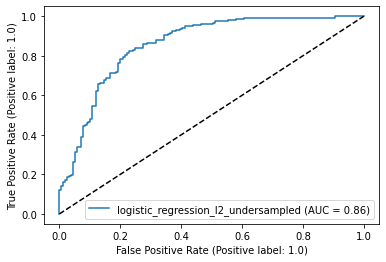

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


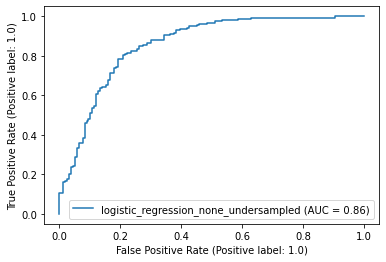

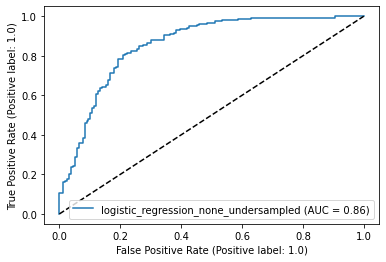

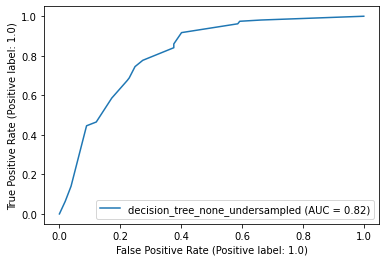

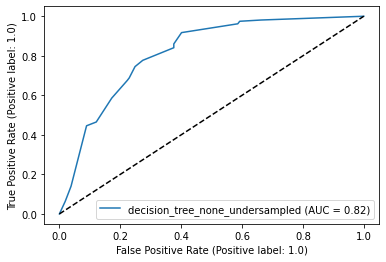

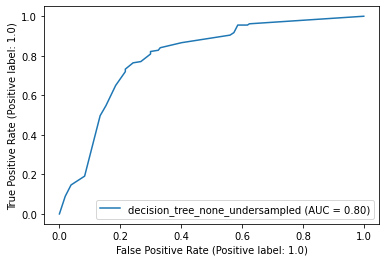

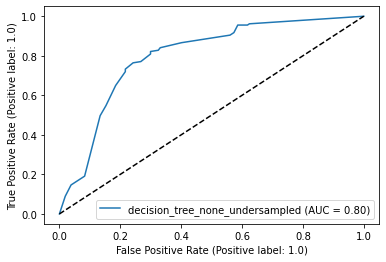

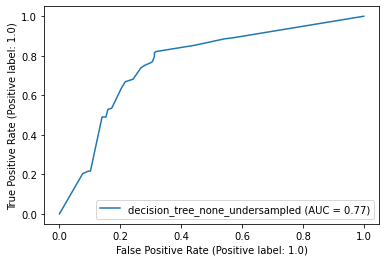

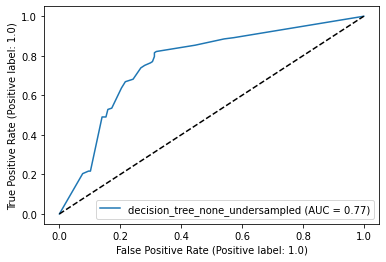

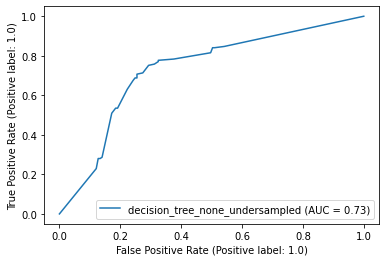

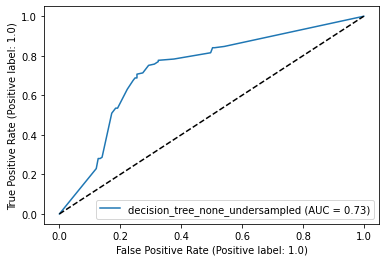

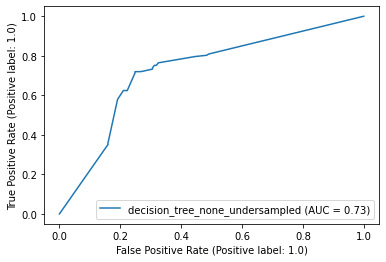

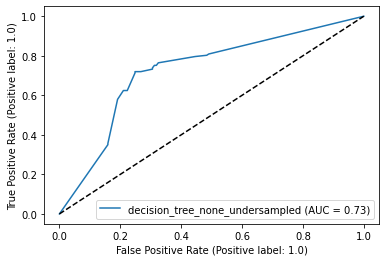

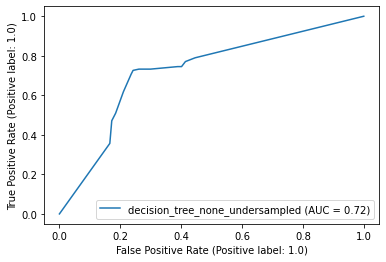

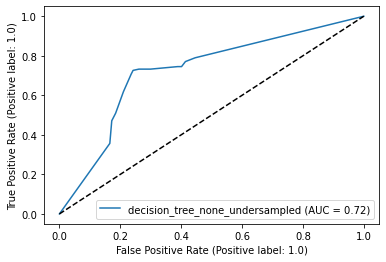

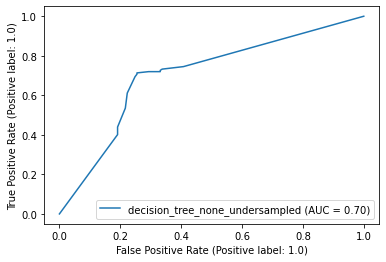

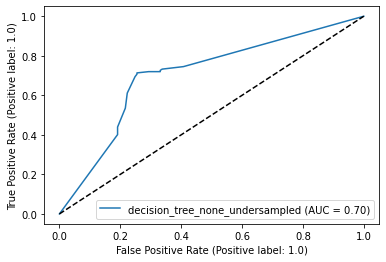

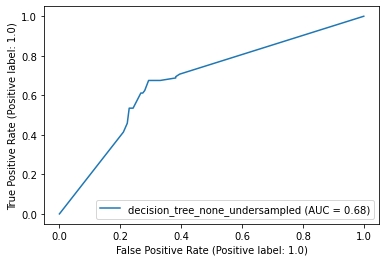

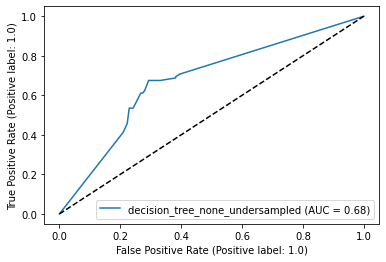

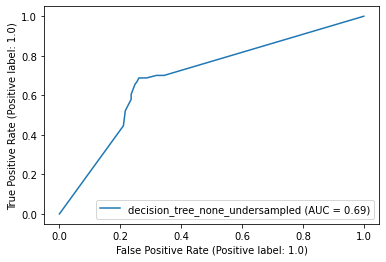

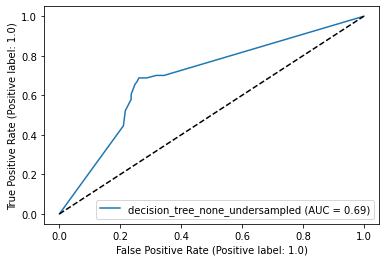

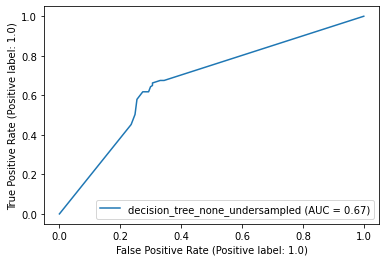

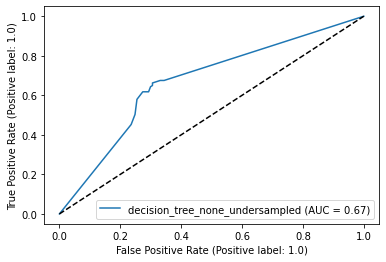

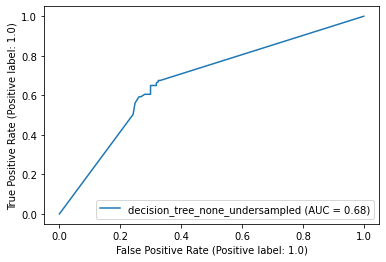

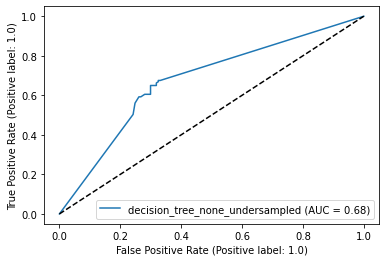

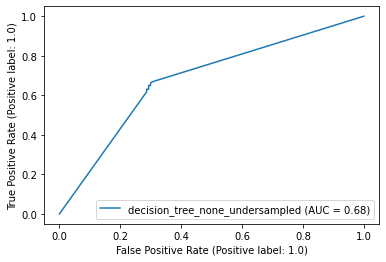

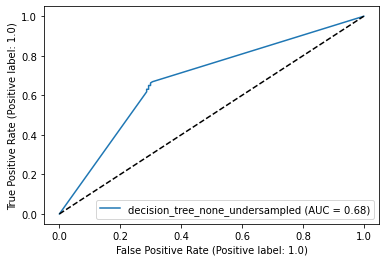

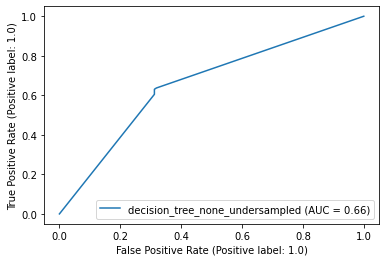

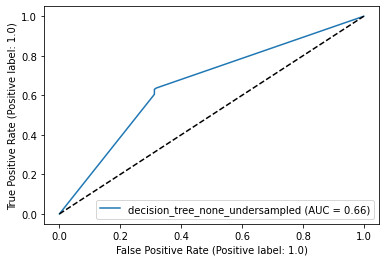

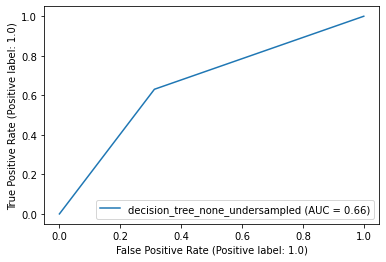

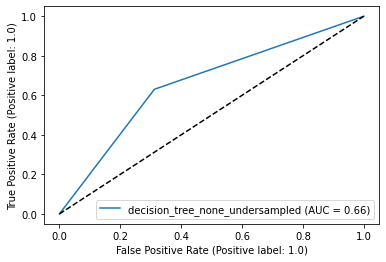

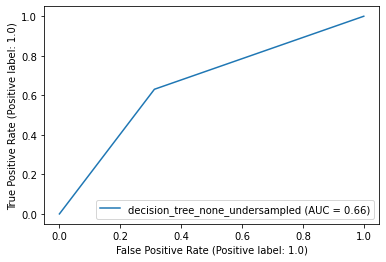

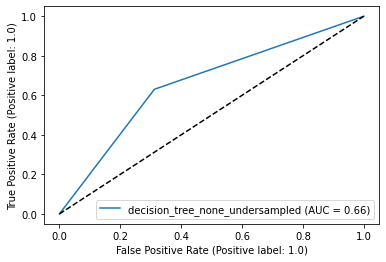

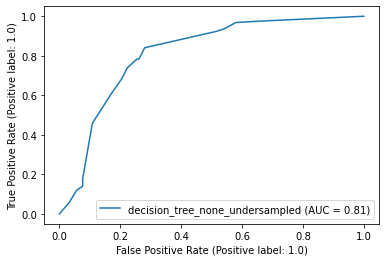

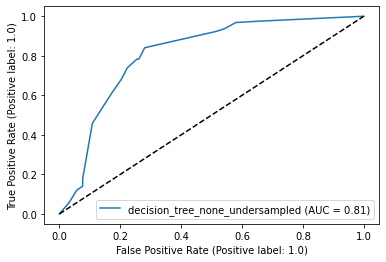

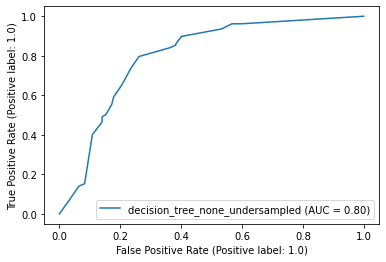

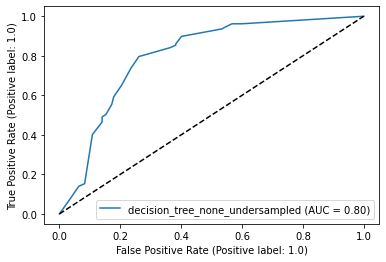

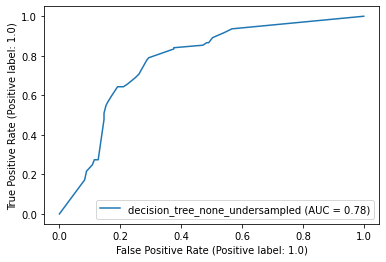

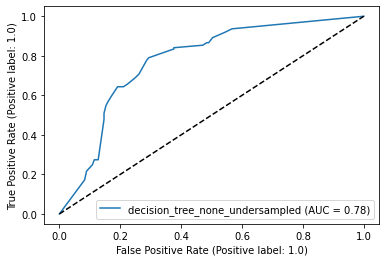

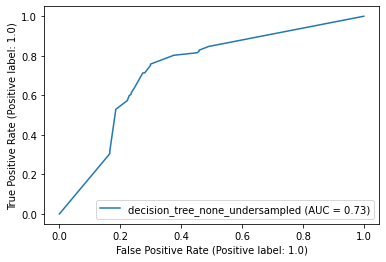

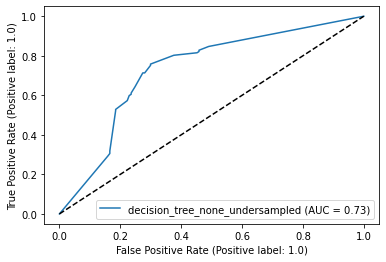

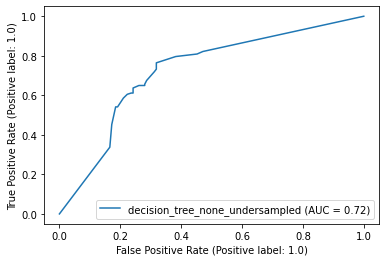

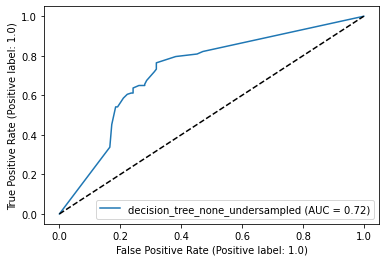

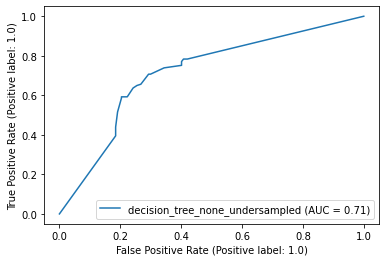

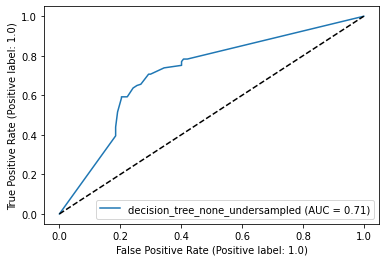

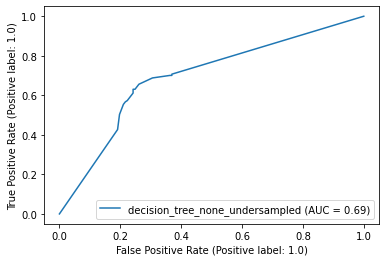

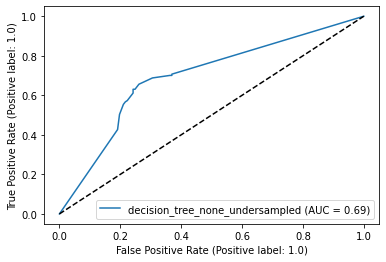

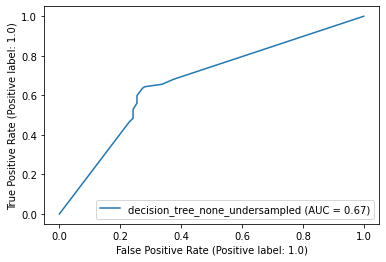

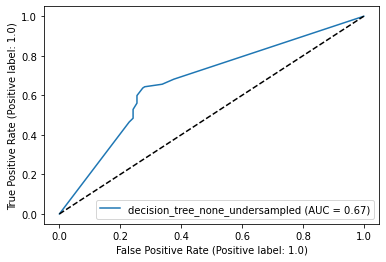

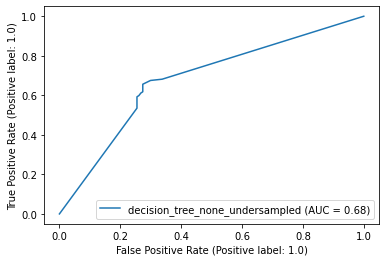

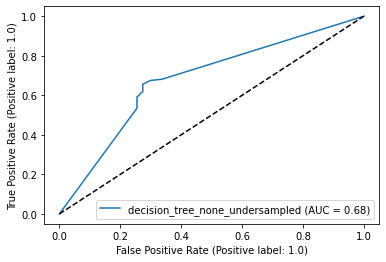

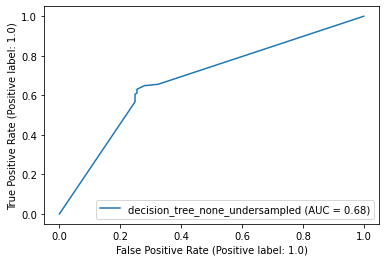

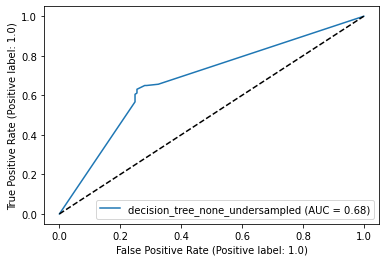

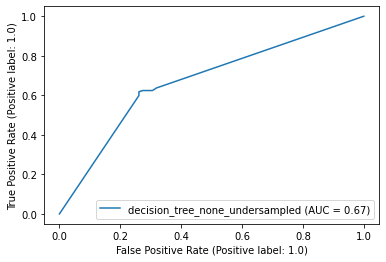

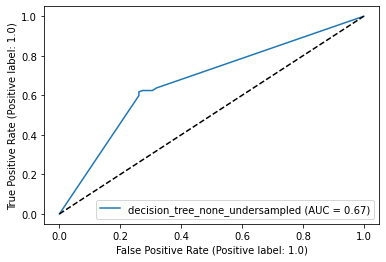

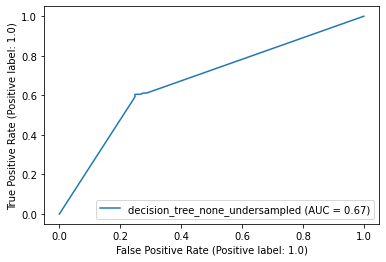

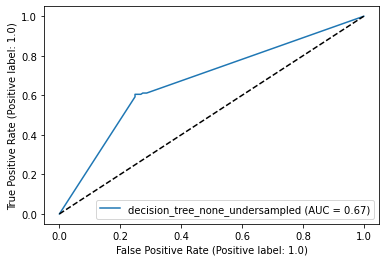

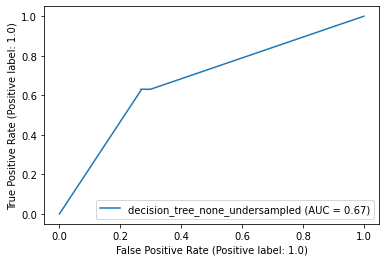

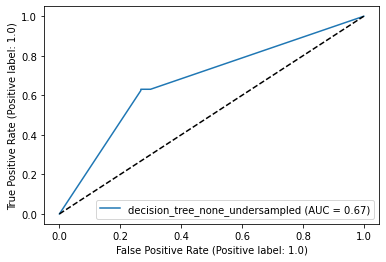

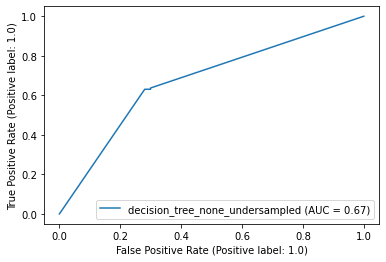

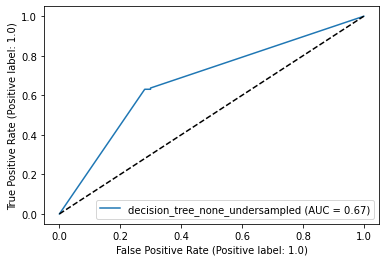

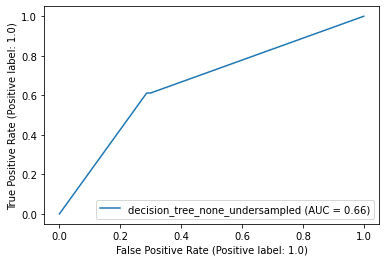

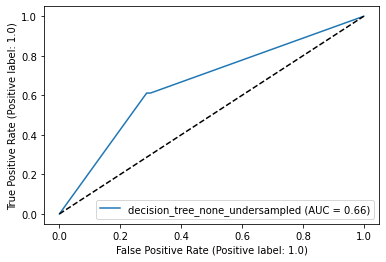

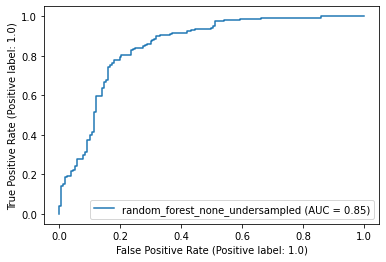

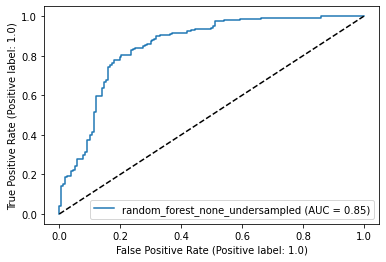

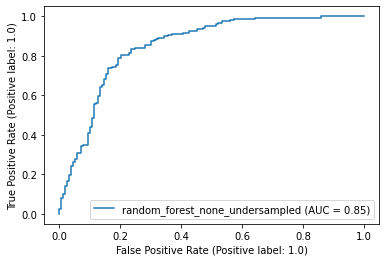

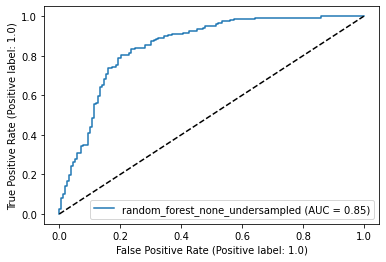

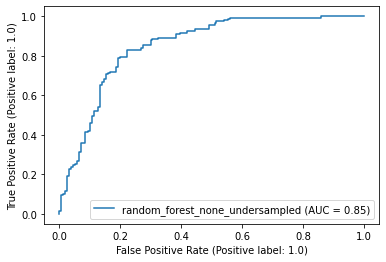

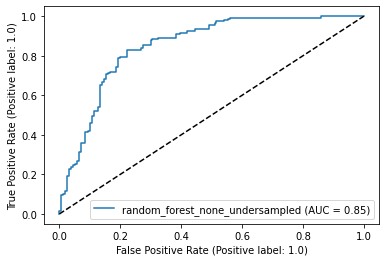

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


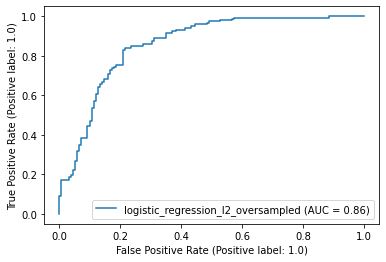

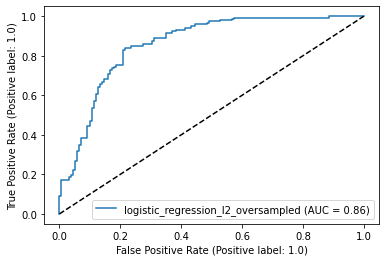

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


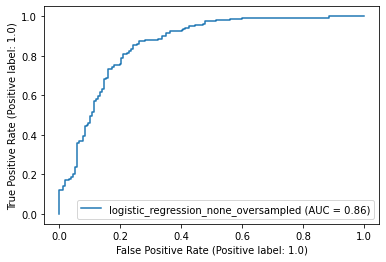

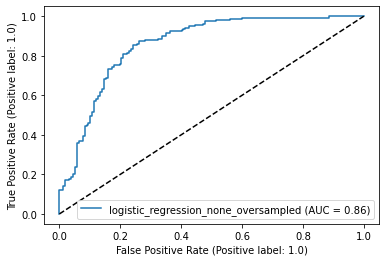

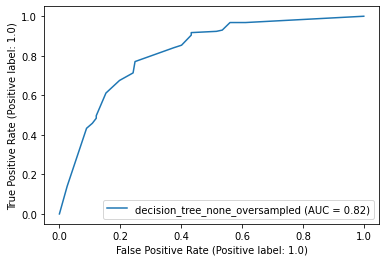

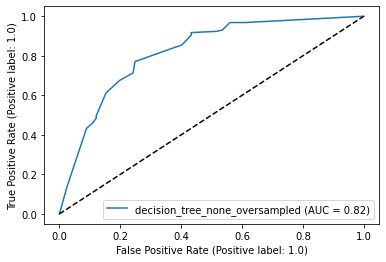

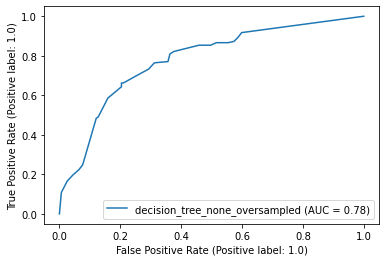

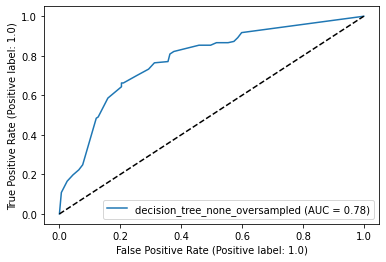

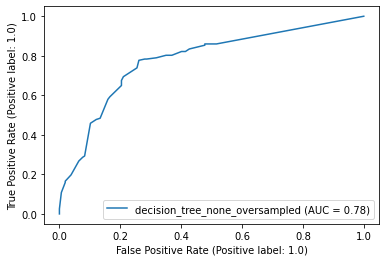

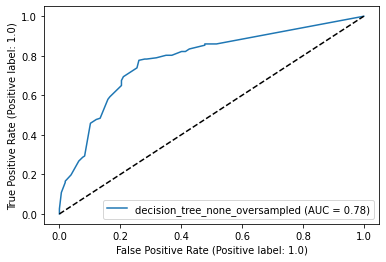

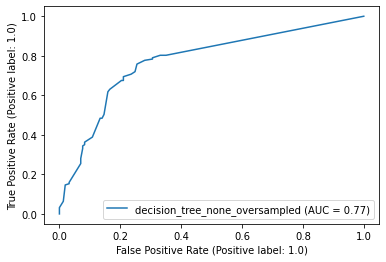

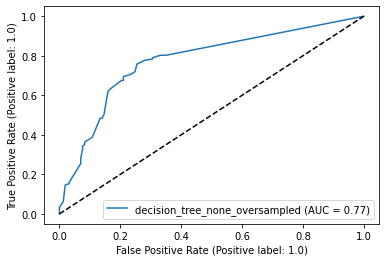

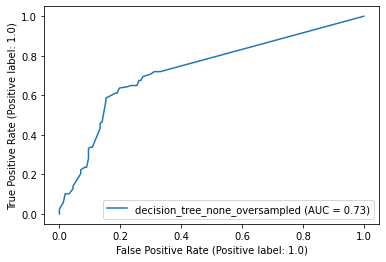

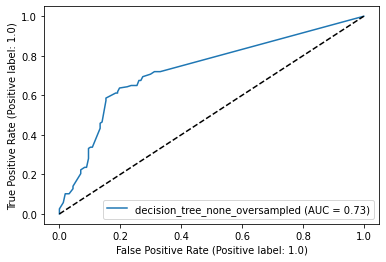

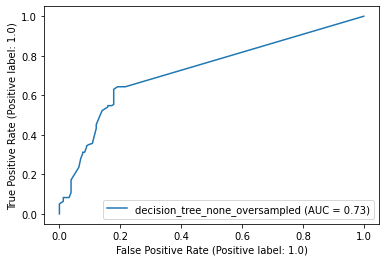

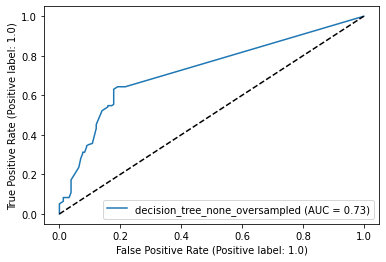

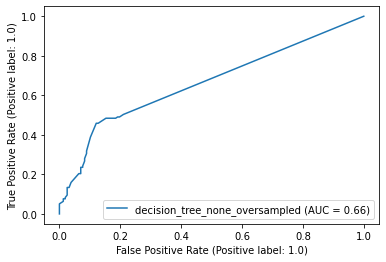

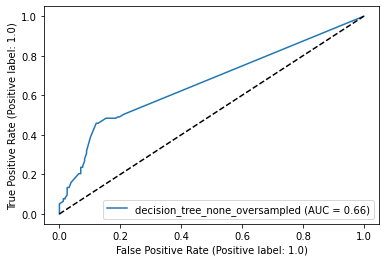

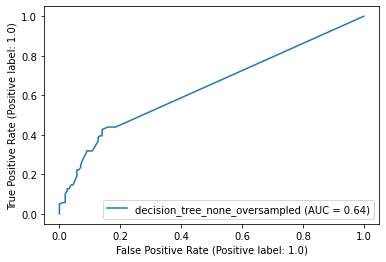

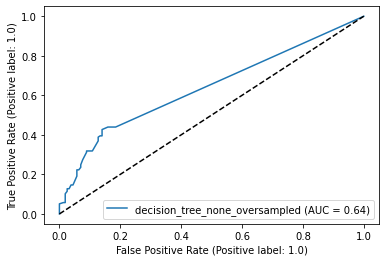

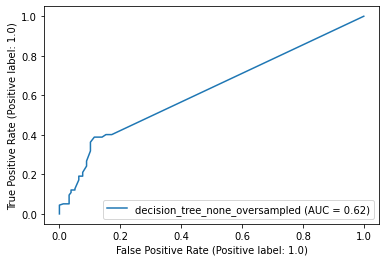

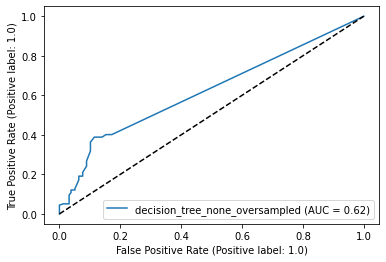

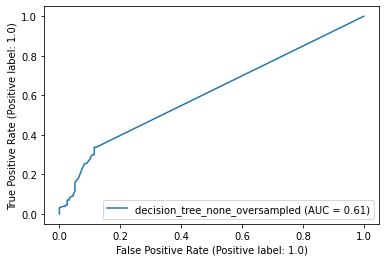

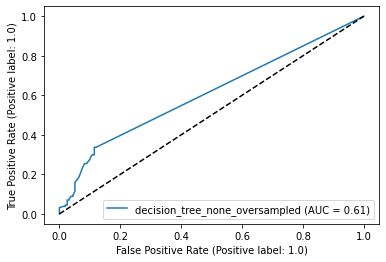

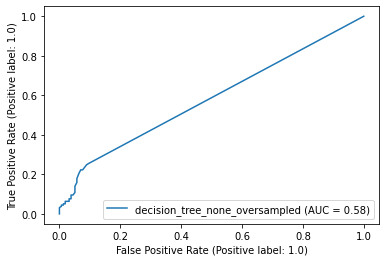

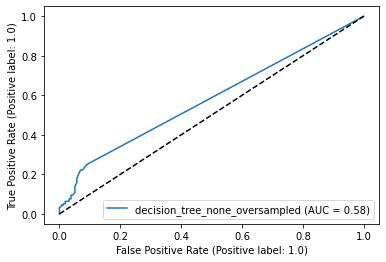

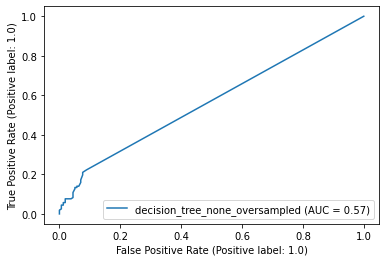

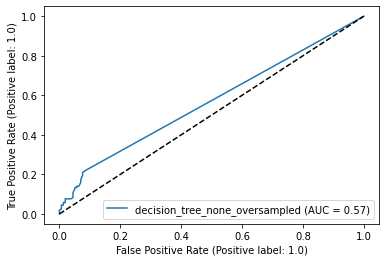

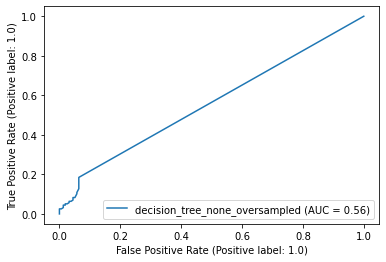

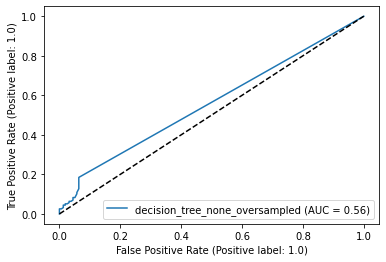

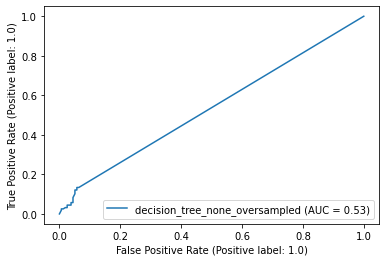

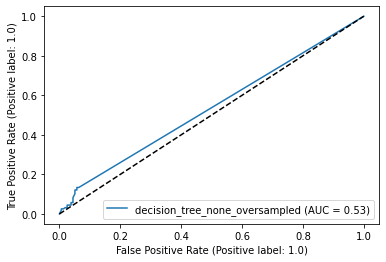

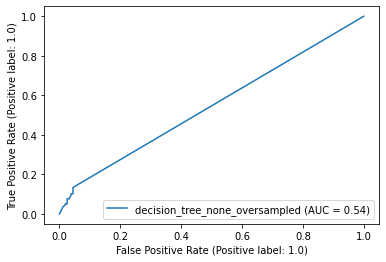

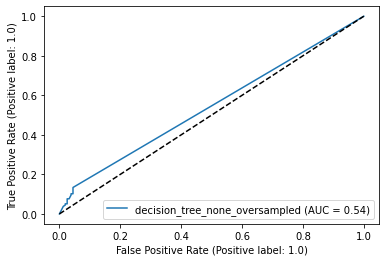

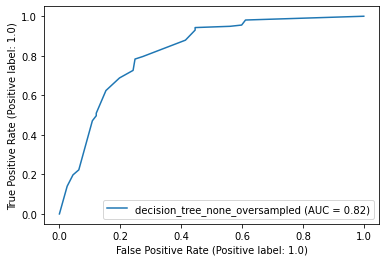

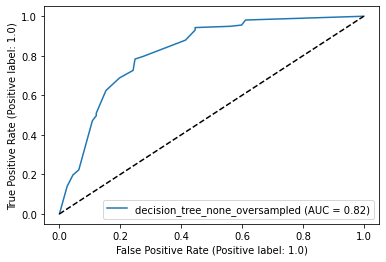

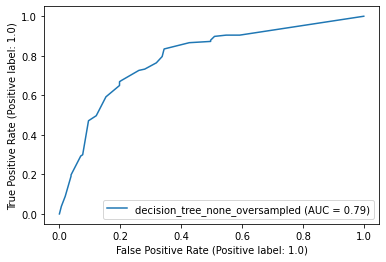

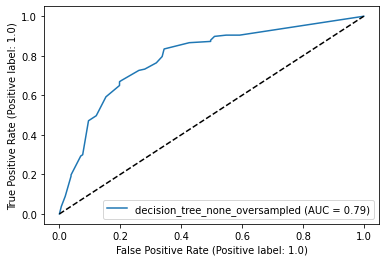

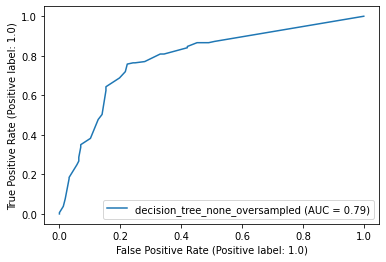

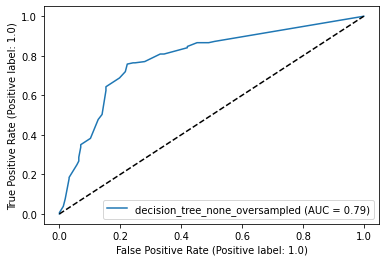

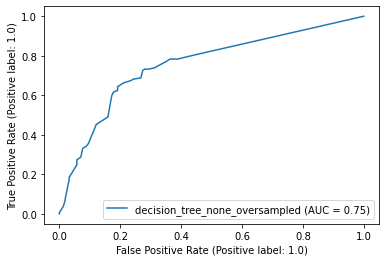

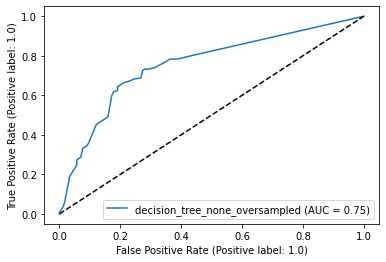

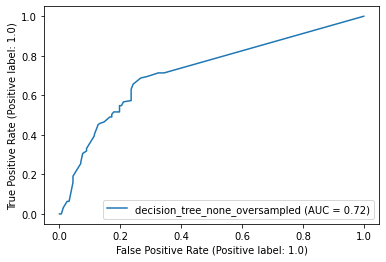

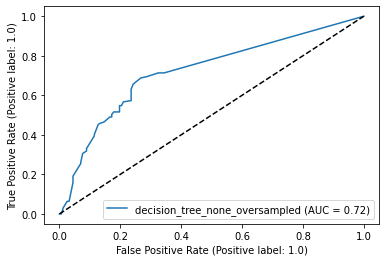

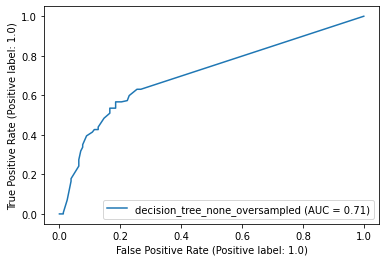

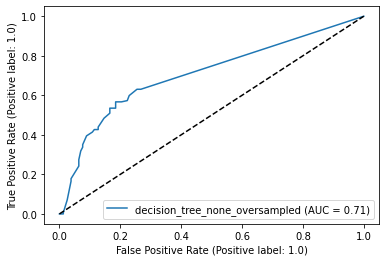

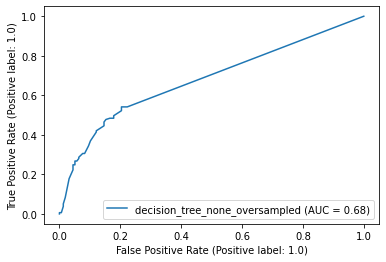

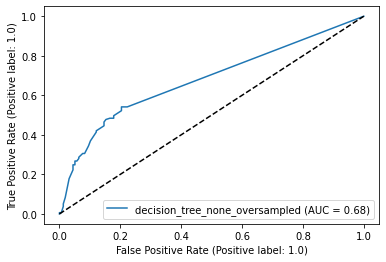

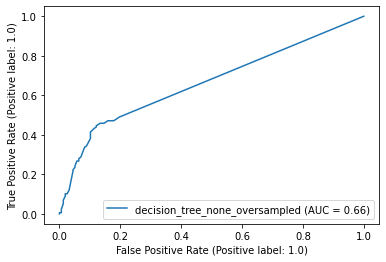

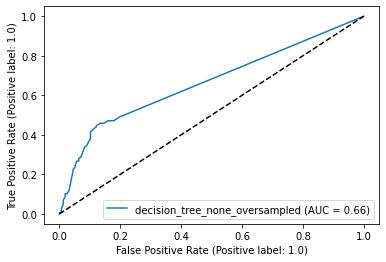

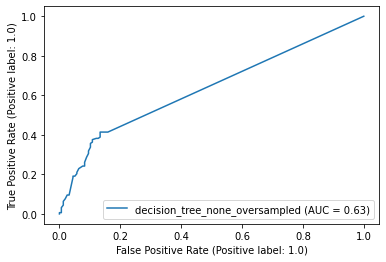

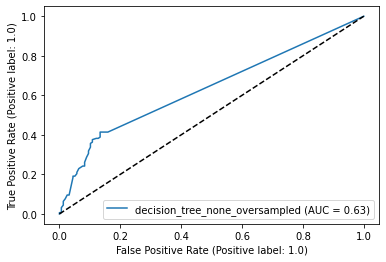

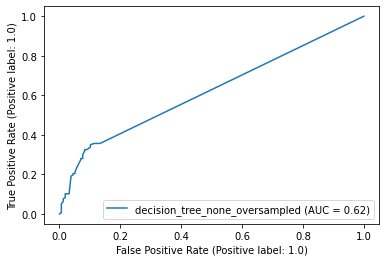

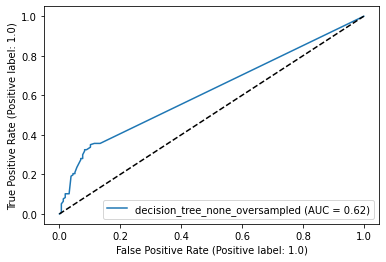

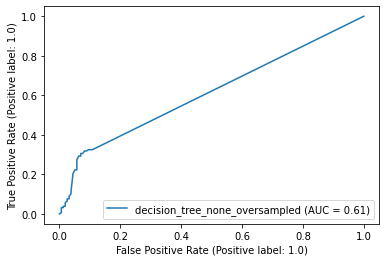

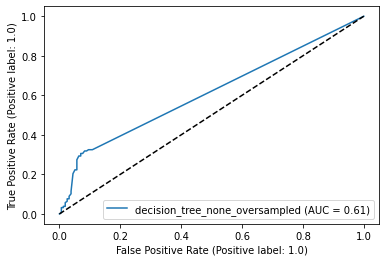

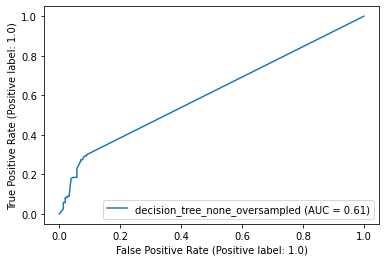

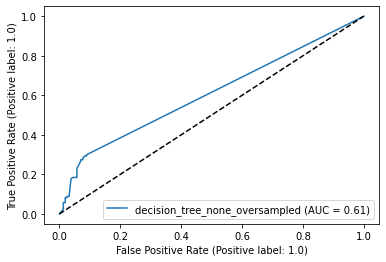

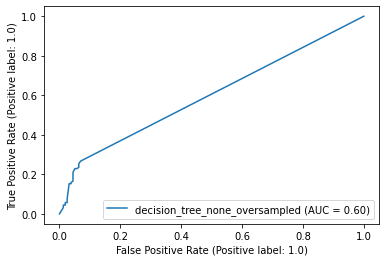

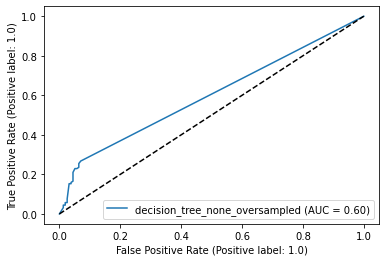

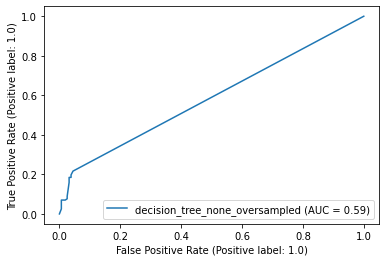

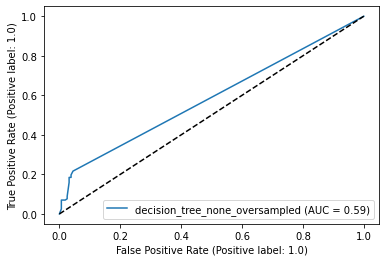

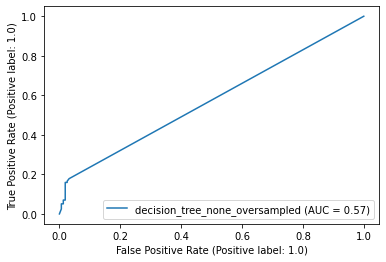

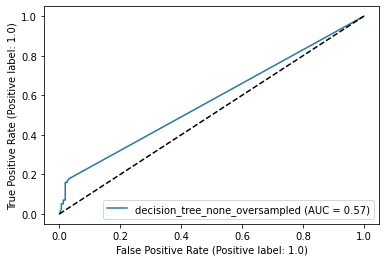

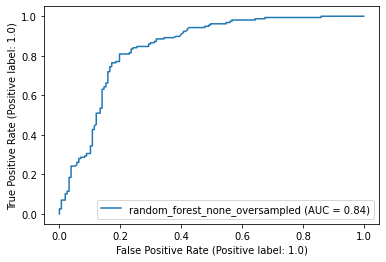

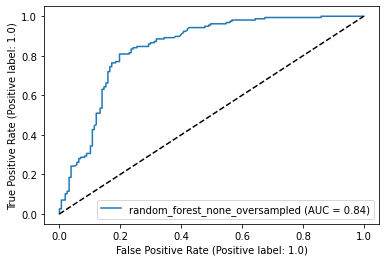

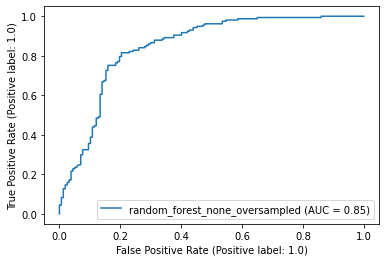

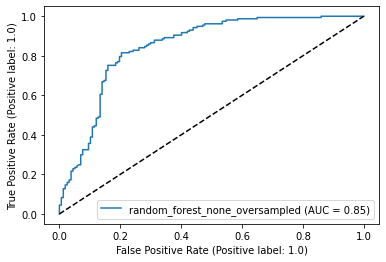

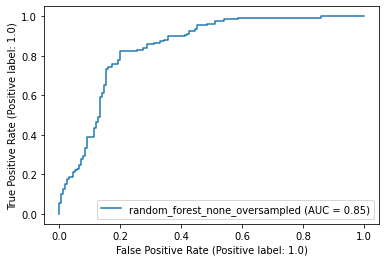

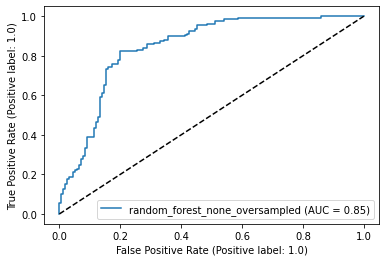

ml_algorithm penalty sampling_method  f1-score  precision  \
0   logistic_regression      l2    undersampled  0.786622   0.786636   
1   logistic_regression    none    undersampled  0.796170   0.796226   
2         decision_tree     NaN    undersampled  0.751431   0.752247   
3         decision_tree     NaN    undersampled  0.754056   0.757800   
4         decision_tree     NaN    undersampled  0.732212   0.733431   
..                  ...     ...             ...       ...        ...   
65        decision_tree     NaN     oversampled  0.520554   0.689359   
66        decision_tree     NaN     oversampled  0.485976   0.702700   
67        random_forest     NaN     oversampled  0.789116   0.793669   
68        random_forest     NaN     oversampled  0.785997   0.790025   
69        random_forest     NaN     oversampled  0.783008   0.785711   

      recall  max_depth criterion  
0   0.786624        NaN       NaN  
1   0.796178        NaN       NaN  
2   0.751592        5.0      gini  
3   0.754777        6.0      gini  
4   0.732484        7.0      gini  
..       ...        ...       ...  
65  0.585987       18.0   entropy  
66  0.570064       19.0   entropy  
67  0.789809        3.0       NaN  
68  0.786624        4.0       NaN  
69  0.783439        5.0       NaN  

[70 rows x 8 columns]

In [60]:
dict_train_test = {
    "undersampled": {
        "train_x": X_train_undersampled,
        "train_y": y_train_undersampled,
    },
    "oversampled": {
        "train_x": X_train_oversampled,
        "train_y": y_train_oversampled
    }
}

list_rows = []

# You should add for loops to include the methods for imputation (esp. smoking: cardinal vs one-hot)

for sampling_method in dict_train_test.keys():
    for ml_algorithm in ["svm", "logistic_regression", "decision_tree", "random_forest", "neural_network"]:
        if ml_algorithm == "logistic_regression":
            # l1 penalty does not work for this solver
            for penalty in ["l2", "none"]:
                clf = LogisticRegression(penalty=penalty, random_state=0).fit(dict_train_test[sampling_method]["train_x"], dict_train_test[sampling_method]["train_y"])
                y_pred = clf.predict(X_test)
                # print(confusion_matrix(y_test, y_pred))
                class_report = classification_report(y_test, y_pred, output_dict=True)
                # print(classification_report(y_test, y_pred, output_dict=True))
                display = RocCurveDisplay.from_estimator(clf, X_test, y_test, 
                                                name=f"{ml_algorithm}_{penalty}_{sampling_method}")
                display.plot()
                plt.plot([0, 1], [0, 1], 'k--')
                plt.savefig(f"{ml_algorithm}_{penalty}_{sampling_method}.jpg", dpi=300)
                plt.show()
                # To save these results and create a final dataframe with all the data, append to list_rows:
                # (You should add a lot more metrics than I did)
                list_rows.append({"ml_algorithm": ml_algorithm,
                                    "penalty": penalty,
                                    "sampling_method": sampling_method,
                                    "f1-score": class_report["weighted avg"]["f1-score"],
                                    "precision": class_report["weighted avg"]["precision"],
                                    "recall": class_report["weighted avg"]["recall"]
                                    })
        elif ml_algorithm == "random_forest":
            for max_depth in [3, 4, 5]:
                clf = RandomForestClassifier(max_depth=max_depth, random_state=42).fit(dict_train_test[sampling_method]["train_x"], 
                                                                                        dict_train_test[sampling_method]["train_y"])
                y_pred = clf.predict(X_test)
                # print(confusion_matrix(y_test, y_pred))
                class_report = classification_report(y_test, y_pred, output_dict=True)
                display = RocCurveDisplay.from_estimator(clf, X_test, y_test, 
                                                name=f"{ml_algorithm}_{penalty}_{sampling_method}")
                display.plot()
                plt.plot([0, 1], [0, 1], 'k--')
                plt.savefig(f"{ml_algorithm}_{penalty}_{sampling_method}.jpg", dpi=300)
                plt.show()
                # print(classification_report(y_test, y_pred, output_dict=True))
                list_rows.append({"ml_algorithm": ml_algorithm,
                                "max_depth": max_depth,
                                "sampling_method": sampling_method,
                                "f1-score": class_report["weighted avg"]["f1-score"],
                                "precision": class_report["weighted avg"]["precision"],
                                "recall": class_report["weighted avg"]["recall"]
                                })
        # elif ml_algorithm == "svm":
        #     for kernel in ["linear", "poly", "rbf", "sigmoid", "precomputed"]:
        #         clf = make_pipeline(StandardScaler(), SVC(kernel=kernel,gamma='auto'))
        #         clf.fit(X_train_oversampled,y_train_oversampled)
        #         y_pred = clf.predict(X_test)
        #         print(confusion_matrix(y_test, y_pred))
        #         class_report = classification_report(y_test, y_pred, output_dict=True)
        #         print(classification_report(y_test, y_pred, output_dict=True))
        #         list_rows.append({"ml_algorithm": ml_algorithm,
        #                         "sampling_method": sampling_method,
        #                         "nonstroke_f1-score": class_report["0"]["f1-score"],
        #                         "stroke_f1-score": class_report["1"]["f1-score"]
        #                         })
            
        elif ml_algorithm =="decision_tree":
            for criterion in ["gini", "entropy"]:
                for max_depth in range(5, 20):
                    clf = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth).fit(dict_train_test[sampling_method]["train_x"], 
                                                                                            dict_train_test[sampling_method]["train_y"])
                    y_pred = clf.predict(X_test)
                    # print(confusion_matrix(y_test, y_pred))
                    class_report = classification_report(y_test, y_pred, output_dict=True)

                    display = RocCurveDisplay.from_estimator(clf, X_test, y_test, 
                                                    name=f"{ml_algorithm}_{penalty}_{max_depth}_{sampling_method}")
                    display.plot()
                    plt.plot([0, 1], [0, 1], 'k--')
                    plt.savefig(f"{ml_algorithm}_{penalty}_{max_depth}_{sampling_method}.jpg", dpi=300)
                    plt.show()
                    # print(classification_report(y_test, y_pred, output_dict=True))
                    list_rows.append({"ml_algorithm": ml_algorithm,
                                    "max_depth": max_depth,
                                    "criterion": criterion,
                                    "sampling_method": sampling_method,
                                    "f1-score": class_report["weighted avg"]["f1-score"],
                                    "precision": class_report["weighted avg"]["precision"],
                                    "recall": class_report["weighted avg"]["recall"]
                                    })
        if ml_algorithm == "neural_network":
            
        

df_all_results = pd.DataFrame(list_rows)
df_all_results
            

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


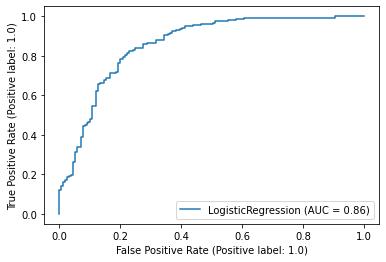

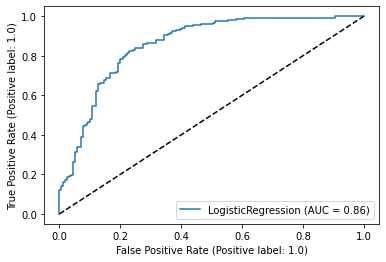

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


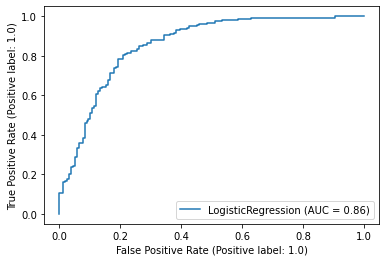

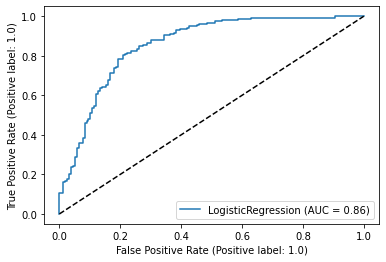

0.7992007789362652


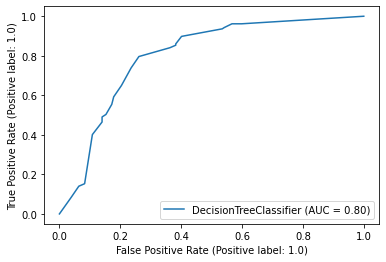

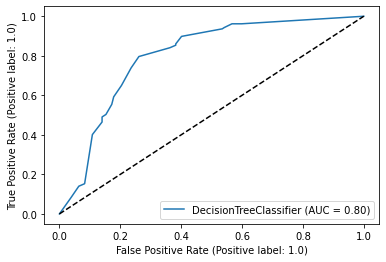

0.7751632926285041


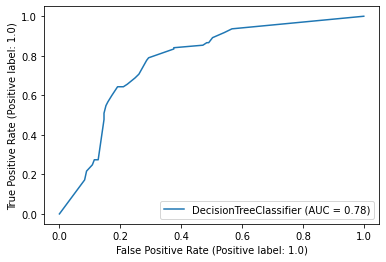

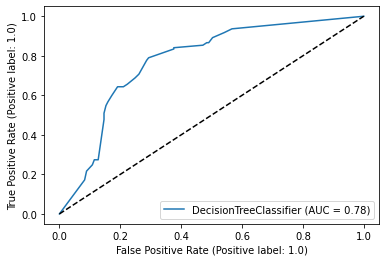

0.72966448943162


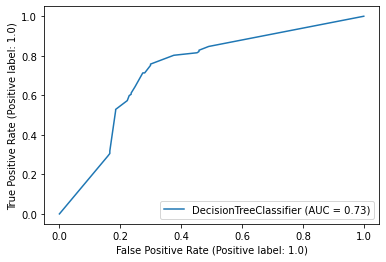

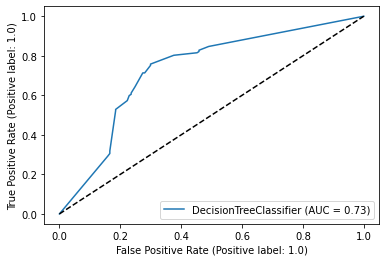

0.7246135745872043


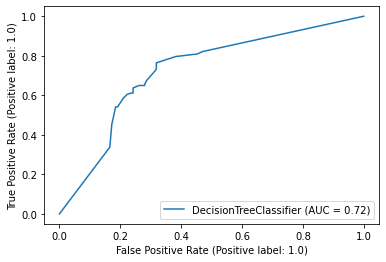

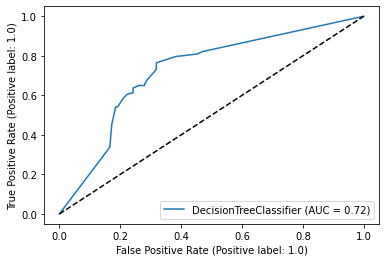

0.7985719501805347


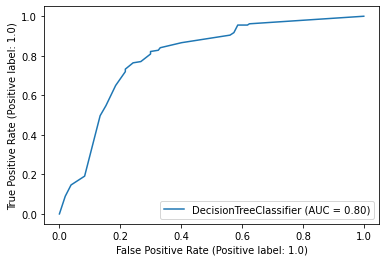

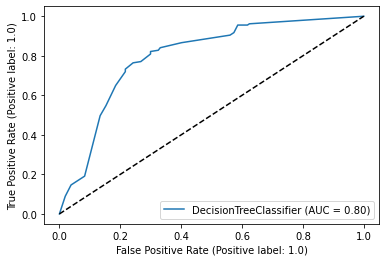

0.7660148484725546


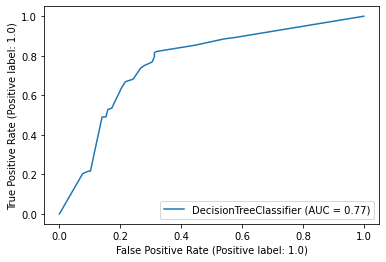

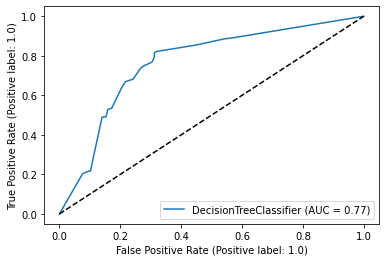

0.730861292547365


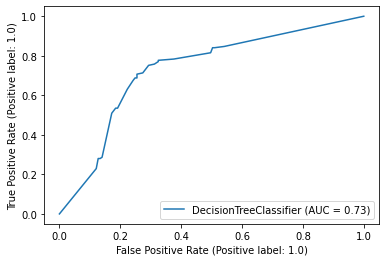

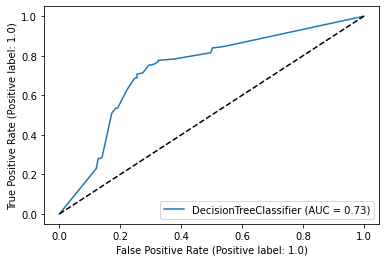

0.7261349344801007


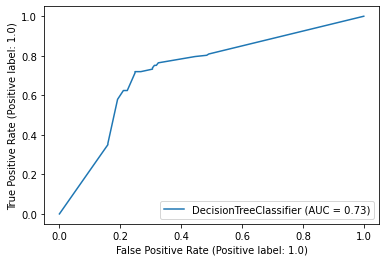

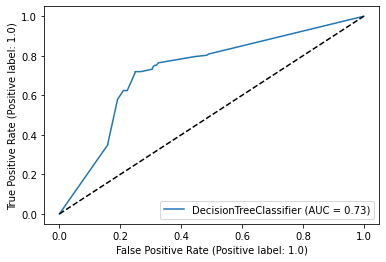

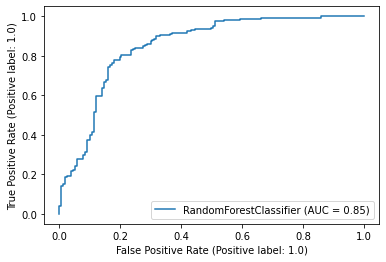

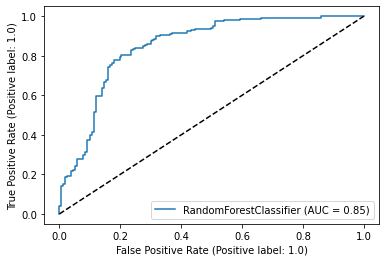

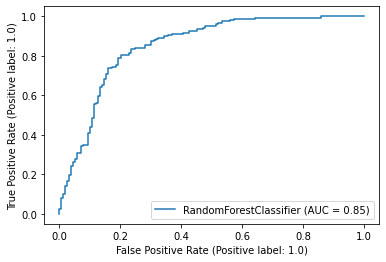

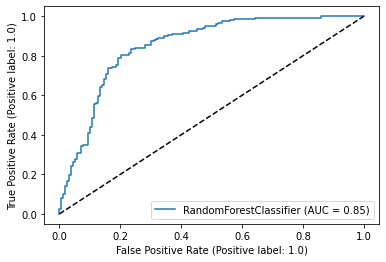

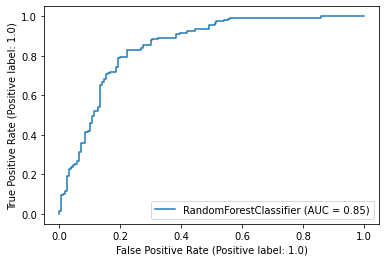

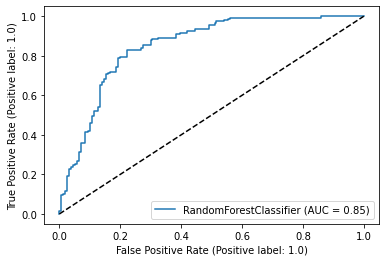

TODO


/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


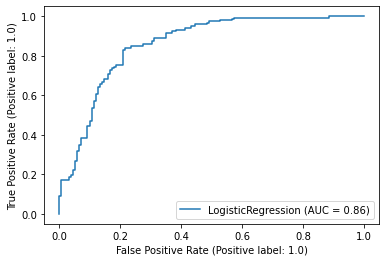

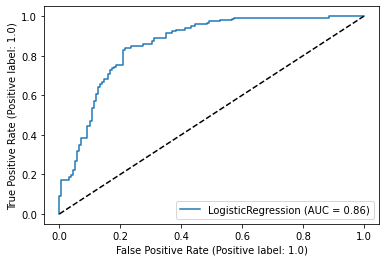

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


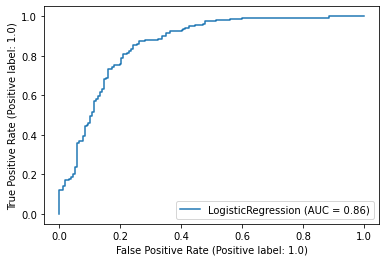

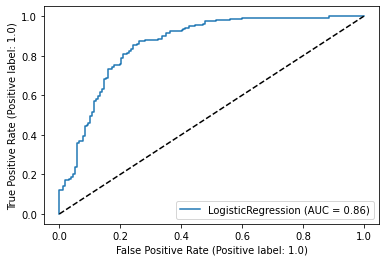

0.790701448334618


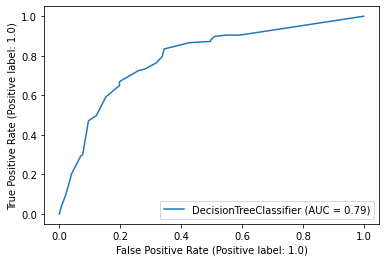

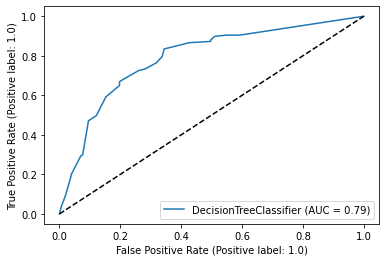

0.7889569556574303


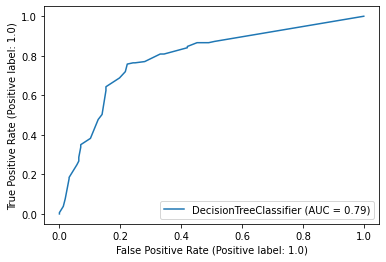

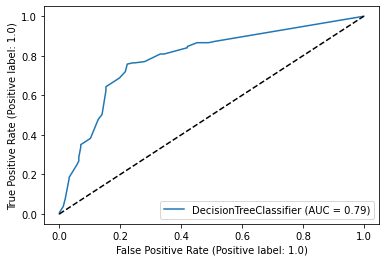

0.7549393484522698


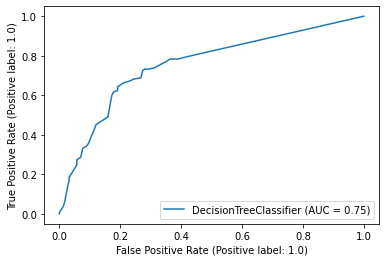

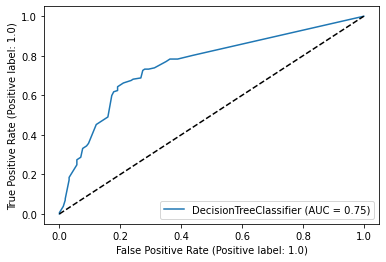

0.7213680068156922


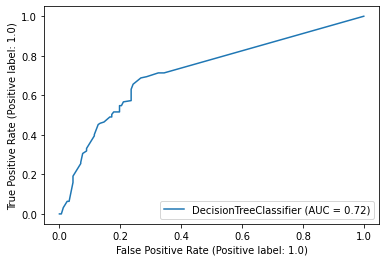

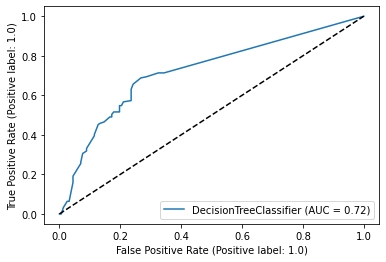

0.7788956955657431


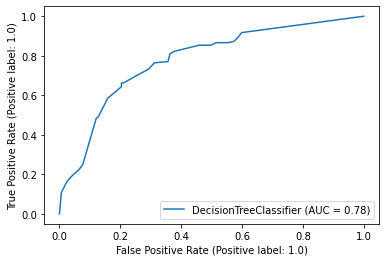

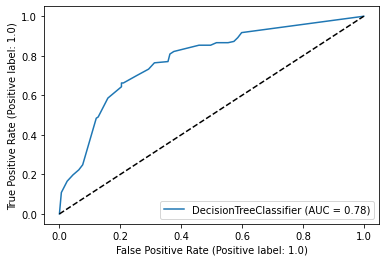

0.7798490810986247


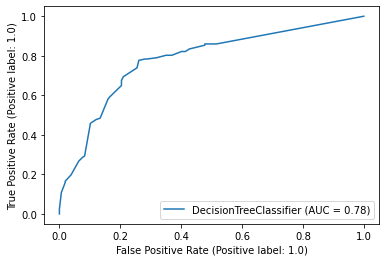

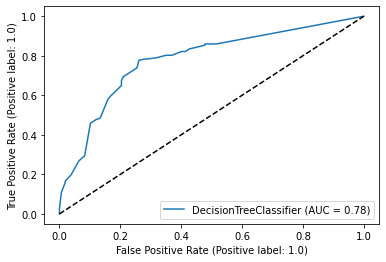

0.7747778814556372


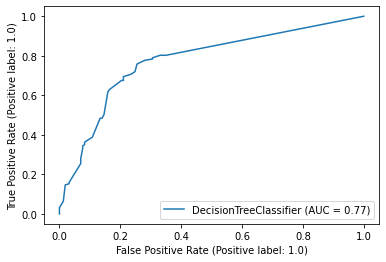

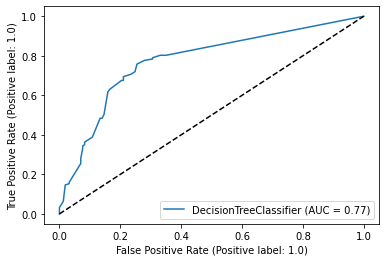

0.7304555965759261


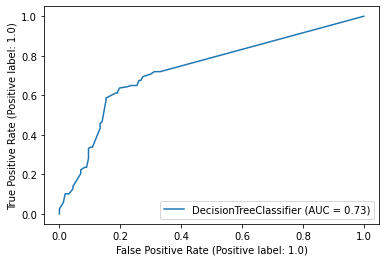

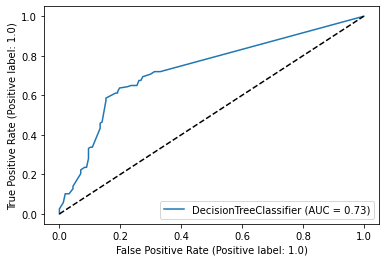

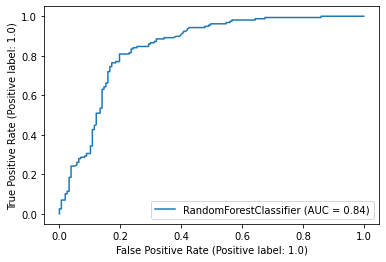

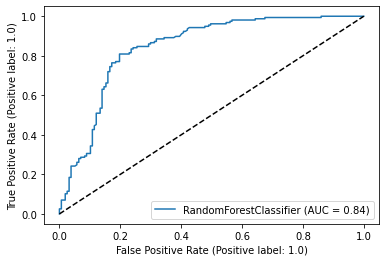

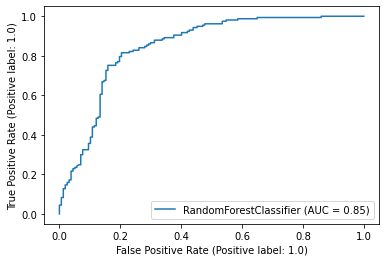

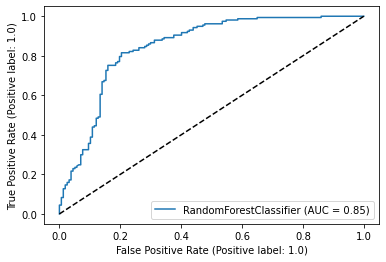

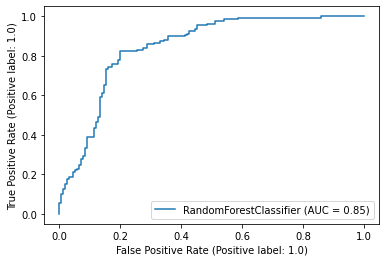

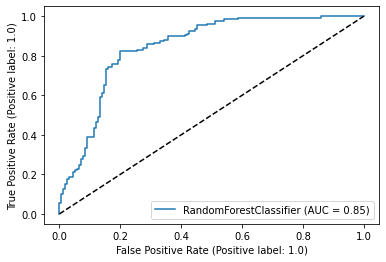

TODO


ml_algorithm penalty sampling_method  f1-score    au_roc  \
0   logistic_regression      l2    undersampled  0.786622  0.858453   
1   logistic_regression    none    undersampled  0.796170  0.856911   
2         decision_tree     NaN    undersampled  0.767325  0.799201   
3         decision_tree     NaN    undersampled  0.719461  0.775163   
4         decision_tree     NaN    undersampled  0.719734  0.729664   
5         decision_tree     NaN    undersampled  0.687581  0.724614   
6         decision_tree     NaN    undersampled  0.754056  0.798572   
7         decision_tree     NaN    undersampled  0.732212  0.766015   
8         decision_tree     NaN    undersampled  0.719734  0.730861   
9         decision_tree     NaN    undersampled  0.726104  0.726135   
10        random_forest     NaN    undersampled  0.789262  0.849771   
11        random_forest     NaN    undersampled  0.785997  0.850542   
12        random_forest     NaN    undersampled  0.782725  0.850947   
13  logistic_regression      l2     oversampled  0.802516  0.859061   
14  logistic_regression    none     oversampled  0.796145  0.859061   
15        decision_tree     NaN     oversampled  0.734697  0.790701   
16        decision_tree     NaN     oversampled  0.744383  0.788957   
17        decision_tree     NaN     oversampled  0.724224  0.754939   
18        decision_tree     NaN     oversampled  0.665739  0.721368   
19        decision_tree     NaN     oversampled  0.722792  0.778896   
20        decision_tree     NaN     oversampled  0.741721  0.779849   
21        decision_tree     NaN     oversampled  0.741448  0.774778   
22        decision_tree     NaN     oversampled  0.708889  0.730456   
23        random_forest     NaN     oversampled  0.789116  0.842712   
24        random_forest     NaN     oversampled  0.785997  0.846221   
25        random_forest     NaN     oversampled  0.783008  0.845308   

    max_depth criterion  
0         NaN       NaN  
1         NaN       NaN  
2         6.0   entropy  
3         7.0   entropy  
4         8.0   entropy  
5         9.0   entropy  
6         6.0      gini  
7         7.0      gini  
8         8.0      gini  
9         9.0      gini  
10        3.0       NaN  
11        4.0       NaN  
12        5.0       NaN  
13        NaN       NaN  
14        NaN       NaN  
15        6.0   entropy  
16        7.0   entropy  
17        8.0   entropy  
18        9.0   entropy  
19        6.0      gini  
20        7.0      gini  
21        8.0      gini  
22        9.0      gini  
23        3.0       NaN  
24        4.0       NaN  
25        5.0       NaN

In [80]:
dict_train_test = {
    "undersampled": {
        "train_x": X_train_undersampled,
        "train_y": y_train_undersampled,
    },
    "oversampled": {
        "train_x": X_train_oversampled,
        "train_y": y_train_oversampled
    }
}

list_rows = []

# You should add for loops to include the methods for imputation (esp. smoking: cardinal vs one-hot)

for sampling_method in dict_train_test.keys():
    for ml_algorithm in ["logistic_regression", "decision_tree", "random_forest", "neural_network"]:
        if ml_algorithm == "logistic_regression":
            # l1 penalty does not work for this solver
            for penalty in ["l2", "none"]:
                clf = LogisticRegression(penalty=penalty, random_state=0).fit(dict_train_test[sampling_method]["train_x"], dict_train_test[sampling_method]["train_y"])
                y_pred = clf.predict(X_test)
                # print(confusion_matrix(y_test, y_pred))
                class_report = classification_report(y_test, y_pred, output_dict=True)
                roc_score = roc_auc_score(y_test, y_pred)
                # print(classification_report(y_test, y_pred, output_dict=True))
                display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
                display.plot()
                plt.plot([0, 1], [0, 1], 'k--')
                plt.savefig(f"final_{ml_algorithm}_{penalty}_{sampling_method}.jpg", dpi=300)
                plt.show()
                # To save these results and create a final dataframe with all the data, append to list_rows:
                # (You should add a lot more metrics than I did)
                list_rows.append({"ml_algorithm": ml_algorithm,
                                    "penalty": penalty,
                                    "sampling_method": sampling_method,
                                    "f1-score": class_report["weighted avg"]["f1-score"],
                                    "au_roc": display.roc_auc
                                    })
        elif ml_algorithm == "random_forest":
            for max_depth in [3, 4, 5]:
                clf = RandomForestClassifier(max_depth=max_depth, random_state=42).fit(dict_train_test[sampling_method]["train_x"], 
                                                                                        dict_train_test[sampling_method]["train_y"])
                y_pred = clf.predict(X_test)
                # print(confusion_matrix(y_test, y_pred))
                class_report = classification_report(y_test, y_pred, output_dict=True)
                roc_score = roc_auc_score(y_test, y_pred)
                display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
                display.plot()
                plt.plot([0, 1], [0, 1], 'k--')
                plt.savefig(f"final_{ml_algorithm}_{penalty}_{sampling_method}.jpg", dpi=300)
                plt.show()
                # print(classification_report(y_test, y_pred, output_dict=True))
                list_rows.append({"ml_algorithm": ml_algorithm,
                                "sampling_method": sampling_method,
                                "max_depth": max_depth,
                                "f1-score": class_report["weighted avg"]["f1-score"],
                                "au_roc": display.roc_auc
                                })
            
        elif ml_algorithm =="decision_tree":
            for criterion in ["entropy", "gini"]:
                for max_depth in [6, 7, 8, 9]:
                    clf = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth).fit(dict_train_test[sampling_method]["train_x"], 
                                                                                            dict_train_test[sampling_method]["train_y"])
                    y_pred = clf.predict(X_test)
                    # print(confusion_matrix(y_test, y_pred))
                    class_report = classification_report(y_test, y_pred, output_dict=True)
                    roc_score = roc_auc_score(y_test, y_pred)
                    display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
                    print(display.roc_auc)
                    display.plot()
                    plt.plot([0, 1], [0, 1], 'k--')
                    plt.savefig(f"final_{ml_algorithm}_{penalty}_{max_depth}_{sampling_method}.jpg", dpi=300)
                    plt.show()
                    # print(classification_report(y_test, y_pred, output_dict=True))
                    list_rows.append({"ml_algorithm": ml_algorithm,
                                    "max_depth": max_depth,
                                    "criterion": criterion,
                                    "sampling_method": sampling_method,
                                    "f1-score": class_report["weighted avg"]["f1-score"],
                                    "au_roc": display.roc_auc
                                    })
        if ml_algorithm == "neural_network":
            print("TODO")
            
        

df_all_results_final = pd.DataFrame(list_rows)
df_all_results_final

In [85]:
clf = LogisticRegression(penalty="l2", random_state=0).fit(dict_train_test["oversampled"]["train_x"], dict_train_test["oversampled"]["train_y"])
y_pred = clf.predict(X_test)

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
clf.coef_.shape

(1, 14)

In [92]:
dict_train_test["oversampled"]["train_x"].std(axis=0)

gender                      0.495945
age                        22.379388
hypertension                0.381212
heart_disease               0.344643
ever_married                0.418696
Residence_type              0.499964
avg_glucose_level          53.638575
bmi                         6.977209
smoking_status_cardinal     0.727781
work_type_Govt_job          0.324277
work_type_Never_worked      0.020872
work_type_Private           0.495793
work_type_Self-employed     0.427554
work_type_children          0.262796
dtype: float64

In [93]:
clf.coef_ * dict_train_test["oversampled"]["train_x"].std(axis=0)

ValueError: Length of passed values is 1, index implies 14.

In [96]:
np.array(dict_train_test["oversampled"]["train_x"].std(axis=0).to_list()) * clf.coef_

array([[-8.40892844e-02,  1.54822203e+00,  1.08788636e-01,
         2.92268175e-01, -2.40986467e-02,  4.73703737e-02,
         2.04292947e-01, -3.53541446e-03,  6.42489751e-02,
        -2.72165170e-01, -5.04320613e-04, -3.48906550e-01,
        -3.02004018e-01, -3.92145707e-01]])

In [100]:
list(dict_train_test["oversampled"]["train_x"].columns)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status_cardinal',
 'work_type_Govt_job',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children']

In [102]:
len(list(dict_train_test["oversampled"]["train_x"].columns))

14

In [106]:
(np.array(dict_train_test["oversampled"]["train_x"].std(axis=0).to_list()) * clf.coef_).tolist()[0]

[-0.0840892844255096,
 1.548222027747918,
 0.10878863609919907,
 0.2922681745579501,
 -0.024098646741300946,
 0.04737037367360543,
 0.20429294699267067,
 -0.003535414463254167,
 0.06424897514991236,
 -0.27216516968703613,
 -0.0005043206125486883,
 -0.3489065495807306,
 -0.30200401784631453,
 -0.3921457074390581]

In [108]:
pd.DataFrame({"features": list(dict_train_test["oversampled"]["train_x"].columns), "importance": (np.array(dict_train_test["oversampled"]["train_x"].std(axis=0).to_list()) * clf.coef_).tolist()[0]}).to_csv("importance_regression.csv", index=False)

In [ ]:
np.array(dict_train_test["oversampled"]["train_x"].std(axis=0).to_list()) * 

In [82]:
df_all_results_final.to_csv("results_all_methods_finalJB.csv", index=False)

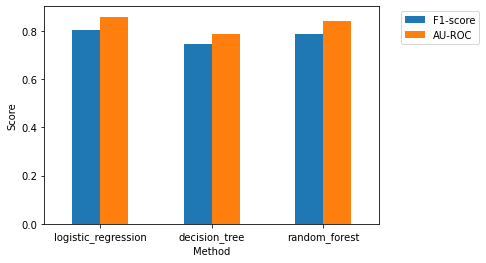

In [77]:
df_graph_data = df_all_results_final.loc[3:6, ["ml_algorithm", "f1-score", "au_roc"]]
df_graph_data.index = df_graph_data["ml_algorithm"]
df_graph_data = df_graph_data.drop(columns="ml_algorithm")
df_graph_data.columns = ["F1-score", "AU-ROC"]

df_graph_data.plot.bar(rot=0)
plt.xlabel("Method")
plt.ylabel("Score")
lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f"final_comparison_all.jpg", dpi=300, bbox_extra_artists=(lg,), 
            bbox_inches='tight')
plt.show()


# df_all_results_final.groupby("ml_algorithm").plot(kind='bar')

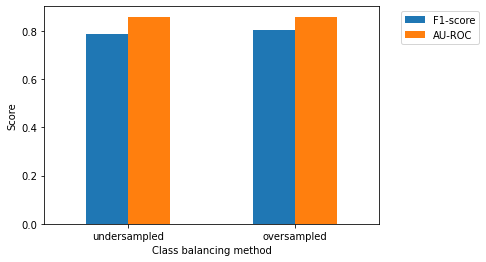

In [78]:
df_graph_data = df_all_results_final.loc[[0,3], ["sampling_method", "f1-score", "au_roc"]]
df_graph_data.index = df_graph_data["sampling_method"]
df_graph_data = df_graph_data.drop(columns="sampling_method")
df_graph_data.columns = ["F1-score", "AU-ROC"]

df_graph_data.plot.bar(rot=0)
plt.xlabel("Class balancing method")
plt.ylabel("Score")
lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f"final_comparison_all_fitting.jpg", dpi=300, bbox_extra_artists=(lg,), 
            bbox_inches='tight')
plt.show()

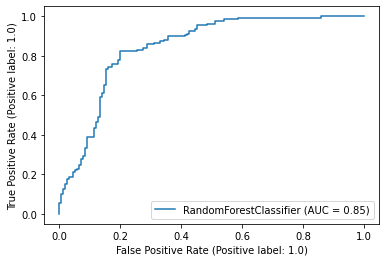

In [47]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [61]:
df_all_results.to_csv("results_all_methods.csv", index=False)

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[116  41]
 [ 27 130]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       157
           1       0.76      0.83      0.79       157

    accuracy                           0.78       314
   macro avg       0.79      0.78      0.78       314
weighted avg       0.79      0.78      0.78       314



# SVM

In [ ]:
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train_oversampled, y_train_oversampled)
# y_pred = clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[128  29]
 [ 54 103]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.82      0.76       157
           1       0.78      0.66      0.71       157

    accuracy                           0.74       314
   macro avg       0.74      0.74      0.73       314
weighted avg       0.74      0.74      0.73       314



# Decision Tree

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_oversampled,y_train_oversampled)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[154   3]
 [150   7]]
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       157
           1       0.70      0.04      0.08       157

    accuracy                           0.51       314
   macro avg       0.60      0.51      0.38       314
weighted avg       0.60      0.51      0.38       314



# Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=42)
clf.fit(X_train_oversampled,y_train_oversampled)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[116  41]
 [ 27 130]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       157
           1       0.76      0.83      0.79       157

    accuracy                           0.78       314
   macro avg       0.79      0.78      0.78       314
weighted avg       0.79      0.78      0.78       314



# Artificial Neural Network - Multilayer perceptron

In [62]:
model = Sequential()
model.add(Dense(10, input_dim=14, activation="relu"))
model.add(Dense(6, input_dim=10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
X_train_oversampled.shape

(84898, 14)

In [65]:
history = model.fit(X_train_oversampled,y_train_oversampled,batch_size=30,epochs=10, verbose=1)

Epoch 1/10
2830/2830 [==============================] - 4s 1ms/step - loss: 0.6872 - accuracy: 0.7279
Epoch 2/10
2830/2830 [==============================] - 3s 899us/step - loss: 0.4800 - accuracy: 0.7675
Epoch 3/10
2830/2830 [==============================] - 3s 917us/step - loss: 0.4712 - accuracy: 0.7742
Epoch 4/10
2830/2830 [==============================] - 3s 924us/step - loss: 0.4667 - accuracy: 0.7759
Epoch 5/10
2830/2830 [==============================] - 3s 937us/step - loss: 0.4647 - accuracy: 0.7776
Epoch 6/10
2830/2830 [==============================] - 3s 950us/step - loss: 0.4634 - accuracy: 0.7779
Epoch 7/10
2830/2830 [==============================] - 3s 1ms/step - loss: 0.4613 - accuracy: 0.7780
Epoch 8/10
2830/2830 [==============================] - 3s 1ms/step - loss: 0.4605 - accuracy: 0.7792
Epoch 9/10
2830/2830 [==============================] - 3s 1ms/step - loss: 0.4589 - accuracy: 0.7794
Epoch 10/10
2830/2830 [==============================] - 3s 1ms/step - l

In [ ]:
model.metrics

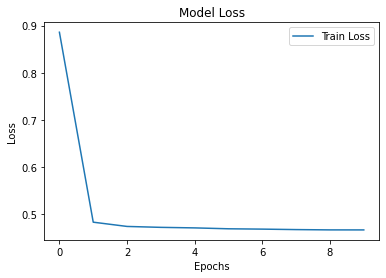

Final value of the loss :  0.4666759669780731
Final value of accuracy : 0.7794647812843323


In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']

plt.plot(history.history['loss'], label='Train Loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

print("Final value of the loss : ", loss[-1])
print("Final value of accuracy :", accuracy[-1])

It seems that the model which performs the most is logistic regression with an accuracy of 0.81. Let's try to train this model on undersample train dataset and to test on the same test set. 

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_oversampled, y_train_oversampled)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
